In [63]:
import os
import matplotlib.pyplot as plt
import umap.plot
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import math
import neuro_morpho_toolbox as nmt
import neuro_morpho_toolbox.plot as nmtp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  

import pickle
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

min_max_scaler = MinMaxScaler()
plt.style.use(['science', 'no-latex'])

def reassign_region_id():
    region_used=nmt.bs.selected_regions
    origin_ccf = np.array(nmt.annotation.array[:, :, :], dtype=np.uint32)
    selected_annotaion = np.zeros_like(nmt.annotation.array, dtype=np.uint32)
    for region in region_used:
        #get its child region
        child_regions = nmt.bs.get_all_child_id(region)
        if len(child_regions) == 0:
            ix, iy, iz = np.where(origin_ccf == region)
            selected_annotaion[ix, iy, iz] = region
            continue
        for childregion in child_regions:
            ix, iy, iz = np.where(origin_ccf == childregion)
            selected_annotaion[ix, iy, iz] = region
    print('processing finished, reassign region id to its parent_id')
    return selected_annotaion

def get_region_swc(cswc,
                   annotation=nmt.annotation,
                   brain_structure=nmt.bs,
                   region_used=None):
    tp = cswc.copy()
    tp = pd.DataFrame(
        {
            "x": np.array(np.array(tp.x),dtype="int32"),
            "y": np.array(np.array(tp.y),dtype="int32"),
            "z": np.array(np.array(tp.z),dtype="int32")
        },
        index=tp.index)
    tp = tp[((tp.x >= 0) & (tp.x < annotation.size['x']) & (tp.y >= 0) &
             (tp.y < annotation.size['y']) & (tp.z >= 0) &
             (tp.z < annotation.size['z']))]

    # Add region id to the dataframe
    if region_used is None:
        region_used = nmt.bs.selected_regions
        dict_to_used = nmt.bs.dict_to_selected
    else:
        assert all([
            (i in brain_structure.level.index.tolist()) for i in region_used
        ]), "Given regions invalid. Please check 'region_used'."
        dict_to_used = {}
        for cur_region in region_used:
            child_ids = nmt.bs.get_all_child_id(cur_region)
            for i in child_ids:
                dict_to_used[i] = cur_region
    tp["region_id"] = np.array(annotation.array[tp.x, tp.y, tp.z], dtype=int)
    tp = tp[tp.region_id.isin(list(dict_to_used.keys()))]
    tp["region_id"] = np.array(tp["region_id"].map(dict_to_used), dtype=int)
    res = cswc.copy()
    res['region_id'] = 0
    res.loc[tp.index, 'region_id'] = tp['region_id']
    return res

def get_soma_region(infile):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 'error'
    soma=inswc[inswc.parent<0].copy()
    soma['x']=soma['x']/25
    soma['y']=soma['y']/25
    soma['z']=soma['z']/25
    somar=get_region_swc(cswc=soma,annotation=my_annotation)
    soma_rid=somar['region_id'].tolist()[0]
    if soma_rid >0:
        return nmt.bs.id_to_name(soma_rid)
    return 'error'

ccf_reassigned_f='/Users/jiangshengdian/Desktop/Daily/multi_level_analysis/axon_motif/ccf_reassigned.pickle'
if os.path.exists(ccf_reassigned_f):
    with open(ccf_reassigned_f,'rb') as f:
        my_annotation=pickle.load(f)
else:
    print('reassign start... will take a long time.')
    selected_annotaion=reassign_region_id()
    my_annotation=nmt.annotation
    my_annotation.array=selected_annotaion
    with open(ccf_reassigned_f,'wb') as f:
        pickle.dump(my_annotation,f)


# soma branching plot
def get_degree(tswc):
    tswc['degree'] = tswc['parent'].isin(tswc.index).astype('int')
    # print(tswc['degree'])
    n_child = tswc.parent.value_counts()
    n_child = n_child[n_child.index.isin(tswc.index)]
    tswc.loc[n_child.index, 'degree'] = tswc.loc[n_child.index, 'degree'] + n_child
    return tswc
def get_rid(swc):
    '''
    Find root node.
    '''
    rnode=swc[((swc['parent']<0) & (swc['type']<=1))]
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_keypoint(swc, rid=None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist = swc[((swc.degree!=2) | (swc.index==rid))].index.tolist()
    return idlist
def swc2branches(swc):
    '''
    reture branch list of a swc
    '''
    keyids=get_keypoint(swc)
    branches=[]
    for key in keyids:
        if swc.loc[key,'parent']<0 | swc.loc[key,'type']<=1:
            continue
        branch=[]
        branch.append(key)
        pkey=swc.loc[key,'parent']
        while True:
            branch.append(pkey)
            if pkey in keyids:
                break
            key=pkey
            pkey=swc.loc[key,'parent']
        branches.append(branch)
    return branches
def swc_plot(file,direction='XY',title=None,linewidth=2,shift=True,xlim=None,ylim=None,fromFile=True):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    colors=['white','black','red','blue','magenta','yellow']
    if fromFile:
        swc=nmt.swc.neuron(file).swc
    else:
        swc=file.copy()
    if shift:
        swc.loc[:,'x']-=swc.loc[:,'x'].min()
        swc.loc[:,'y']-=swc.loc[:,'y'].min()
        swc.loc[:,'z']-=swc.loc[:,'z'].min()
    swc_brs=swc2branches(swc)
    for br in swc_brs:
        br_color=colors[int(swc.loc[br[0],'type'])]
        br_coords=swc.loc[br,['x','y','z']].copy()
        Xe=br_coords['x'].to_list()
        Ye=br_coords['y'].to_list()
        Ze=br_coords['z'].to_list()
        if direction=='YZ':
            ax.plot(Ye, Ze, c=br_color,linewidth=linewidth)
            ax.set_xlabel('Y',fontsize=10)
            ax.set_ylabel('Z',fontsize=10) 
        elif direction=='XZ':
            ax.plot(Xe, Ze, c=br_color,linewidth=linewidth)
            ax.set_xlabel('X',fontsize=10)
            ax.set_ylabel('Z',fontsize=10) 
        else:
            ax.plot(Xe, Ye, c=br_color,linewidth=linewidth)
            ax.set_xlabel('X',fontsize=10)
            ax.set_ylabel('Y',fontsize=10)
    if title is not None:
        ax.set_title(title,fontsize=12)
    if xlim is not None:
        ax.set_xlim(xlim) 
    if ylim is not None:
        ax.set_ylim(ylim)      
    return fig, ax
def motifs_plot(files,direction='XY',title=None,linewidth=2,shift=True,fontsize=12,compare=0):
    '''compare==0: max
    compare!=0: with the compare size
    '''
    fsize=len(files)
    basic_width=5
    colors=['white','black','red','blue','magenta','yellow']
    fig, cax = plt.subplots(1,fsize, figsize=(fsize*basic_width,basic_width),dpi=100)
    xmax=0
    ymax=0
    zmax=0
    swcs=[]
    for file in files:
        swc=nmt.swc.neuron(file).swc
        if shift:
            swc.loc[:,'x']-=swc.loc[:,'x'].min()
            swc.loc[:,'y']-=swc.loc[:,'y'].min()
            swc.loc[:,'z']-=swc.loc[:,'z'].min()
        xmax=swc.loc[:,'x'].max() if swc.loc[:,'x'].max() > xmax else xmax
        ymax=swc.loc[:,'y'].max() if swc.loc[:,'y'].max() > ymax else ymax
        zmax=swc.loc[:,'z'].max() if swc.loc[:,'z'].max() > zmax else zmax
        swcs.append(swc) 
    for i,swc in enumerate(swcs):
        ax = cax[i]
        # swc=nmt.swc.neuron(file).swc
        swc_brs=swc2branches(swc)
        for br in swc_brs:
            br_color=colors[int(swc.loc[br[0],'type'])]
            br_coords=swc.loc[br,['x','y','z']].copy()
            Xe=br_coords['x'].to_list()
            Ye=br_coords['y'].to_list()
            Ze=br_coords['z'].to_list()
            if direction=='YZ':
                ax.plot(Ye, Ze, c=br_color,linewidth=linewidth)
                xamax=ymax
                yamax=zmax
                xlabel_text='Y'
                ylabel_text='Z'
            elif direction=='XZ':
                ax.plot(Xe, Ze, c=br_color,linewidth=linewidth)
                xamax=xmax
                yamax=zmax
                xlabel_text='X'
                ylabel_text='Z'
            else:
                ax.plot(Xe, Ye, c=br_color,linewidth=linewidth)
                xamax=xmax
                yamax=ymax
                xlabel_text='X'
                ylabel_text='Y'
        if compare==0:
            ax.set_xlim([0,xamax])
            ax.set_ylim([0,yamax])
        elif compare >0:
            ax.set_xlim([0,compare])
            ax.set_ylim([0,compare])
        ax.set_xlabel(xlabel_text,fontsize=fontsize)
        ax.set_ylabel(ylabel_text,fontsize=fontsize)  
        if title is not None:
            ax.set_title(title[i],fontsize=fontsize)
    return fig, ax

In [120]:
def nodes_dis(swc,n1,n2):
    if n1 not in swc.index or n2 not in swc.index:
        return None
    x1=swc.loc[n1,'x']
    y1=swc.loc[n1,'y']
    z1=swc.loc[n1,'z']
    x2=swc.loc[n2,'x']
    y2=swc.loc[n2,'y']
    z2=swc.loc[n2,'z']
    return math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2))
def soma2motif(file,pca=True,tofile=None,shift=True,dis_thre=5):
    swc=nmt.swc.neuron(file).swc
    rid=get_rid(swc)
    brs=swc2branches(swc)
    key_nodes=[]
    key_nodes.append(rid)
    # dis_thre=5
    for br in brs:
        knode=br[0]
        brdis=0
        for n in np.arange(1,len(br)):
            brdis+=nodes_dis(swc,br[-1*n],br[-1*(n+1)])
            if brdis>dis_thre:
                # for ensuring tip node to soma distance is below dist_thre
                knode=br[-1*(n+1)]
                break
        if knode == br[0]:
            continue
        key_nodes.append(knode)
    if len(key_nodes)<=1:
        return None
    somaswc=swc.loc[key_nodes,:].copy()
    somaswc['parent']=rid
    somaswc.loc[rid,'parent']=-1
    if pca and somaswc.shape[0]>2:
        # print(somaswc.shape[0])
        svalues=somaswc[['x','y','z']].values
        # print(svalues)
        ss=StandardScaler().fit_transform(svalues)
        X_pca = PCA(n_components=3).fit_transform(ss)
        # print(ss)
        somaswc['x']=X_pca[:,0]
        somaswc['y']=X_pca[:,1]
        somaswc['z']=X_pca[:,2]
    if shift:
        ridx=somaswc.loc[rid,'x']
        ridy=somaswc.loc[rid,'y']
        ridz=somaswc.loc[rid,'z']
        somaswc['x']-=ridx
        somaswc['y']-=ridy
        somaswc['z']-=ridz
    if tofile is not None:
        somaswc.to_csv(tofile,sep=' ')
    return somaswc

In [123]:
# pca of soma motif
pcasomapath='/Users/jiangshengdian/Desktop/Daily/multi_level_analysis/axon_motif/motif/soma/pca'
somapath='/Users/jiangshengdian/Desktop/Daily/multi_level_analysis/axon_motif/motif/soma/soma_swc'
rawsomapath='/Users/jiangshengdian/Desktop/Daily/multi_level_analysis/axon_motif/motif/soma/soma_motif_swc'
dis_thre=5
for root,dirs,files in os.walk(rawsomapath):
    for mfile in files:
        if os.path.splitext(mfile)[1] != '.swc':
            continue
        file_in=os.path.join(root,mfile)
        file_out=os.path.join(somapath,mfile)
        soma2motif(file_in,pca=False,tofile=file_out,dis_thre=dis_thre)
        
        file_out2=os.path.join(pcasomapath,mfile)
        soma2motif(file_in,pca=True,tofile=file_out2,dis_thre=dis_thre)
        # break


In [162]:
#get distribution features

fea_names=[]
for i in np.arange(1,27):
    fea_names.append('b'+str(i))
a_feas=pd.DataFrame(columns=fea_names)
for root,dirs,files in os.walk(pcasomapath):
    for mfile in files:
        if os.path.splitext(mfile)[1] != '.swc':
            continue
        file_in=os.path.join(root,mfile)
        findex=mfile.split('.s')[0]+'.eswc.csv'
        swc=nmt.swc.neuron(file_in).swc
        swc.loc[:,'x']-=swc.loc[:,'x'].min()
        swc.loc[:,'y']-=swc.loc[:,'y'].min()
        swc.loc[:,'z']-=swc.loc[:,'z'].min()
        xmax=swc.loc[:,'x'].max()
        ymax=swc.loc[:,'y'].max()
        zmax=swc.loc[:,'z'].max()
        
        fea=[]
        for ix in np.arange(0,3):
            ix_min=ix*xmax/3
            ix_max=(ix+1)*xmax/3
            for iy in np.arange(0,3):
                iy_min=iy*ymax/3
                iy_max=(iy+1)*ymax/3
                for iz in np.arange(0,3):
                    iz_min=iz*zmax/3
                    iz_max=(iz+1)*zmax/3
                    if ix==1 & iy ==1 & iz==1:
                        continue
                    fea.append(swc[(swc.x>ix_min)&(swc.x<=ix_max) & (swc.y>iy_min)&(swc.y<=iy_max) & (swc.z>iz_min)&(swc.z<=iz_max)].shape[0])
        a_feas.loc[findex,:]=fea
a_feas.index.name='name'
a_feas.to_csv('/Users/jiangshengdian/Desktop/Daily/multi_level_analysis/axon_motif/angle_distribution_feas.csv')

In [165]:
a_feas.index.name='name'
a_feas.to_csv('/Users/jiangshengdian/Desktop/Daily/multi_level_analysis/axon_motif/angle_distribution_feas.csv')

In [159]:
sf='/Users/jiangshengdian/Desktop/Daily/multi_level_analysis/axon_motif/motif/soma/pca/18455_00146.swc'
swc=nmt.swc.neuron(sf).swc
swc.loc[:,'x']-=swc.loc[:,'x'].min()
swc.loc[:,'y']-=swc.loc[:,'y'].min()
swc.loc[:,'z']-=swc.loc[:,'z'].min()
xmax=swc.loc[:,'x'].max()
ymax=swc.loc[:,'y'].max()
zmax=swc.loc[:,'z'].max()
# fea=pd.DataFrame({'x':[]})
# for i in np.arange(1,swc.shape[0]-1):
fea=[]
for ix in np.arange(0,3):
    ix_min=ix*xmax/3
    ix_max=(ix+1)*xmax/3
    for iy in np.arange(0,3):
        iy_min=iy*ymax/3
        iy_max=(iy+1)*ymax/3
        for iz in np.arange(0,3):
            iz_min=iz*zmax/3
            iz_max=(iz+1)*zmax/3
            if ix==1 & iy ==1 & iz==1:
                continue
            fea.append(swc[(swc.x>ix_min)&(swc.x<=ix_max) & (swc.y>iy_min)&(swc.y<=iy_max) & (swc.z>iz_min)&(swc.z<=iz_max)].shape[0])


In [163]:
a_feas

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26
17545_00145.eswc.csv,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
18864_00420.eswc.csv,0,0,1,2,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
17545_00179.eswc.csv,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
17109_7001_x6205_y5194.eswc.csv,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
18463_00046.eswc.csv,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18453_4693_x33039_y11636.eswc.csv,0,0,0,1,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
18458_00121.eswc.csv,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
18465_00312.eswc.csv,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
18453_2428_x13810_y8197.eswc.csv,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

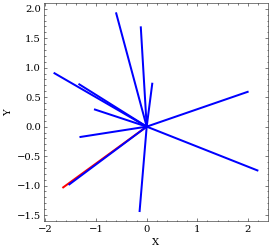

In [147]:
swc_plot(swc,fromFile=False,direction='XY',shift=False)

In [153]:
swc[['x','y','z']]

,type,x,y,z,r,parent
##n,,,,,,
1,1,1.820749,1.431338,1.450766,0.230000,-1
6,2,0.172293,0.401166,0.855709,0.553472,1
693,3,4.006942,0.688769,0.758352,0.423200,1
701,3,1.680958,0.000000,2.489307,0.605581,1
712,3,1.930236,2.159281,0.000000,0.553472,1
724,3,3.814157,2.021433,1.377868,0.500480,1
735,3,1.218873,3.352948,1.959716,0.605581,1
748,3,1.704410,3.115397,0.697231,0.605581,1
831,3,0.490305,2.148182,1.126250,0.500480,1


In [141]:
centroids=pd.DataFrame()
for root,dirs,files in os.walk(pcasomapath):
    for mfile in files:
        if os.path.splitext(mfile)[1] != '.swc':
            continue
        file_in=os.path.join(root,mfile)
        findex=mfile.split('.s')[0]+'.eswc.csv'
        swc=nmt.swc.neuron(file_in).swc
        centroswc=swc[(swc.x!=0) & (swc.y!=0) & (swc.z!=0)].copy()
        centroidx=centroswc.loc[:,'x'].mean()
        centroidy=centroswc.loc[:,'y'].mean()
        centroidz=centroswc.loc[:,'z'].mean()
        centroid2soma_dist=math.sqrt(centroidx*centroidx+centroidy*centroidy+centroidz*centroidz)
        centroids.loc[findex,'centroidx']=float(centroidx)
        centroids.loc[findex,'centroidy']=float(centroidy)
        centroids.loc[findex,'centroidz']=float(centroidz)
        centroids.loc[findex,'centroid2soma_dist']=float(centroid2soma_dist)
        # break
centroids.index.name='name'
centroids.to_csv('/Users/jiangshengdian/Desktop/Daily/multi_level_analysis/axon_motif/soma_centroid_fea.csv')

In [145]:
centroids.describe()

,centroidx,centroidy,centroidz,centroid2soma_dist
count,1775.000000,1775.000000,1775.000000,1775.000000
mean,-0.193970,-0.119782,-0.031827,0.990991
std,0.698983,0.733098,0.685596,0.752629
min,-4.980000,-4.570000,-5.460000,0.008180
25%,-0.516525,-0.416496,-0.370674,0.528635
50%,-0.221409,-0.105054,0.013467,0.799180
75%,0.088860,0.208596,0.386044,1.225396
max,4.840000,5.380000,4.870000,6.727927
